In [1]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as sci

from marvin.tools.vacs import VACs
from astropy.io import fits
import numpy as np
from marvin.tools import Maps
from marvin.tools import Cube

from marvin import config #Needed to fix "Cube not subscriptable" when running in Sciserver
config.forceDbOff() #Needed to fix "Cube not subscriptable" when running in Sciserver

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')
#importing necessary functions

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


In [2]:
selection = 'all_data.fits'
hdu = fits.open(selection)
data = hdu[1].data
#importing sample data

In [3]:
non_usable=np.array([])

for i in range(len(data)):
    if data[i]['mngtarg3']!=0:
        non_usable=np.append(non_usable,str(data[i]['plateifu_1']))
#selecting galaxies in the third MaNGA targets sample

In [4]:
#Calculate fractional mass error
def massexcess(sigmass_ma, sigmass_mi, f):

    err_ma = sigmass_ma #std, and this is the error on log of value, hence the same as the fractional error on the value. 
    err_mi = sigmass_mi
    err_f = f*np.sqrt(err_ma**2 + 2*err_mi**2) # err_not is twice becauses it's in the denominator

    return err_f

In [5]:
plateifus=data['plateifu_1']
sig_ma=data['sigmass_ma'].astype('float')
sig_mi=data['sigmass_mi'].astype('float')
fun=data['mass_excess'].astype('float')
cnt_ma=data['count_ma'].astype('float')
cnt_mi=data['count_mi'].astype('float')
err_f=np.absolute(massexcess(sig_ma,sig_mi,fun))
#getting fractional mass errors for the sample

In [6]:
usable=np.array([])
rad=np.array([])
m_ma=np.array([])
m_mi=np.array([])
f=np.array([])
sigmass_ma=np.array([])
sigmass_mi=np.array([])
count_ma=np.array([])
count_mi=np.array([])
for i in range(len(plateifus)):
    if plateifus[i] not in non_usable and err_f[i]!=np.nan and err_f[i]<0.5 and cnt_ma[i]>10 and cnt_mi[i]>10:
        usable=np.append(usable,data[i]['plateifu_1'])
        rad=np.append(rad,float(data[i]['radius']))
        m_ma=np.append(m_ma,float(data[i]['arm_mass']))
        m_mi=np.append(m_mi,float(data[i]['interarm_mass']))
        f=np.append(f,float(data[i]['mass_excess']))
        sigmass_ma=np.append(sigmass_ma,float(data[i]['sigmass_ma']))
        sigmass_mi=np.append(sigmass_mi,float(data[i]['sigmass_mi']))
        count_ma=np.append(count_ma,float(data[i]['count_ma']))
        count_mi=np.append(count_mi,float(data[i]['count_mi']))
#selecting galaxies not in the third MaNGA target sample, and bins that have adequate error values and number of points in them

In [7]:
print(len(usable))
used_galaxies=[]
for i in usable:
    if i not in used_galaxies:
        used_galaxies.append(i)
print(len(used_galaxies))
#counting final number of bins and galaxies used

5788
1015


In [12]:
#selecting good points for the line plot
masses=np.array([])
radius=np.array([])
delta = (rad[1]-rad[0])/2.0 #to put plot points in middle of bin
excess_mean,radius_mean,binnumber = sci.binned_statistic(rad,f,bins=25,range=[0,3])
excess_err,radius_mean,binnumber = sci.binned_statistic(rad,f,bins=25,range=[0,3],statistic='std')
excess_count,radius_mean,binnumber = sci.binned_statistic(rad,f,bins=25,range=[0,3],statistic='count')
for i in range(len(excess_count)):
    if excess_count[i]>10 and excess_mean[i]!=np.nan:
        masses=np.append(masses,excess_mean[i])
        radius=np.append(radius,radius_mean[i])

Text(0.5, 1.0, 'Excess of Stellar Mass in Spiral Arms')

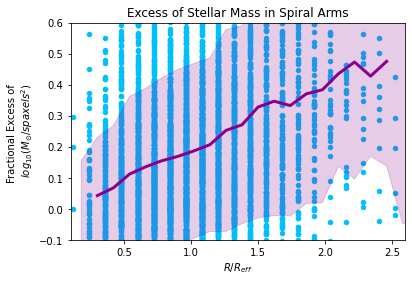

In [26]:
#excess mass average plot for the sample of galaxies as a function of radius

plt.scatter(rad,f,s=20,c='deepskyblue')

plt.plot(radius+delta, masses,c='darkmagenta',linewidth=3)
plt.fill_between(radius_mean[:-1]+delta, excess_mean-excess_err,excess_mean+excess_err,alpha=0.2,color='darkmagenta')
plt.ylim(-0.1,0.6)
plt.xlim(0.1,2.6)

plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Fractional Excess of \n $log_{10}(M_{\odot}/spaxels^2)$')
plt.title('Excess of Stellar Mass in Spiral Arms')